# An Improved Reliability-Based Approach to Sepcifying Fire Resistance Periods For Buildings in England

Analysis documentation for the research topic submitted for ASFE 2021.

_2021 April, Ian F._

In the design of fire safety provisions for straightforward/common buildings in England the appropriate structural fire resistance is selected from guidance based upon building height and occupancy characteristics. This has been expanded upon in contemporary guidance to include consideration of ventilation conditions informed by work carried out in 2004 by Kirby, et al. in their paper “A new approach to specifying fire resistance periods” and has been implemented in British Standard, BS 9999:2017. In the work of Kirby, et al., a probabilistic time equivalence analysis was carried out using Monte Carlo simulations (MCS). Stochastic parameters were used to produce a range of credible design fires. These were primarily fuel load density, compartment geometry and ventilation opening size. The design fires were generated using the parametric fire model in EN 1991-1-2 and the contribution of sprinklers was considered through a reduced fire load. To link to existing fire resistance recommendations which did not consider ventilation, the safety/reliability target was calibrated to align with statutory guidance, Approved Document B (ADB), using a medium-rise office as an anchor point.

This study revisits the work of Kirby et al., resolving key limitations and incorporating advancements in the field to present a new approach to assessing the recommended fire resistance for structures and proposes a revised fire resistance design table for England. To seek alignment with general structural design principles/requirements, as defined in Approved Document A (ADA), safety targets are expressed in function of consequence classes in lieu of building height and use. Other key advancements include improved stochastic parameters, the use of travelling fires where post-flashover parametric fires are unrealistic (i.e., a more explicit consideration of large enclosure fire dynamics), and consideration of sprinkler contribution in the event tree in terms of their ability to mitigate structurally significant fire occurrences.

The improved approach presented provides a more up to date method for defining appropriate fire resistance for straightforward/common buildings in England.

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import pprint as pp
import matplotlib.pyplot as plt
from os import path
from scipy import stats
from typing import Callable, Union
from scipy.interpolate import interp1d
from IPython.display import display, HTML

from sfeprapy.mcs2 import MCS2, EXAMPLE_INPUT_DF
from sfeprapy.mcs.mcs_gen_2 import InputParser

plt.style.use('seaborn-white')

In [2]:
# Helper function: return a function f(fractile) = teq
def make_func_cdf2teq(teq: np.ndarray) -> Callable:
    hist, edges = np.histogram(teq, bins=np.arange(0, max(361, max(teq[teq < np.inf]) + 0.5), 0.5))
    teq, fractile = (edges[:-1] + edges[1:]) / 2, np.cumsum(hist / np.sum(hist))
    return interp1d(fractile, teq, bounds_error=False)


# Helper function: return a function f(teq) = fractile
def make_func_teq2cdf(teq: np.ndarray) -> Callable:
    hist, edges = np.histogram(teq, bins=np.arange(0, max(361, max(teq[teq < np.inf]) + 0.5), 0.5))
    teq, fractile = (edges[:-1] + edges[1:]) / 2, np.cumsum(hist / np.sum(hist))
    return interp1d(teq, fractile, bounds_error=False)


def func_A2cdf(A: np.ndarray, beta: np.ndarray, p_1: float, p_2: float, p_3: float, p_4: float):
    """Calculate time equivalence CDF for a given building total floor area and betas.
    
    Solve:
                             P_f_fi = P_a_fi
    p_1 * A * p_2 * p_3 * p_4 * p_5 = P_a_fi(H)
                                p_5 = P_a_fi(H) / (p_1 * A * p_2 * p_3 * p_4)
                        1 - teq_cdf = P_a_fi(H) / (p_1 * A * p_2 * p_3 * p_4)
                            teq_cdf = 1 - P_a_fi(H) / (p_1 * A * p_2 * p_3 * p_4)
    """
    # solve/interpolate teq cdf
    P_a_fi = stats.norm(loc=0, scale=1).cdf(-beta)
    teq_cdf = 1 - np.divide(P_a_fi, p_1 * A * p_2 * p_3 * p_4, dtype=np.float64)
    return teq_cdf

In [15]:
def plot_contour_text_p_i(ax, title, p_i, x=0.95, y=0.97, va='top', ha='right', bbox_pad=-0.01, bbox_fc=(1, 1, 1, 0.5)):
    ax.text(
        x, y,
        f'{title}\n'
        f'$p_1$={p_i["p_1"]}\n'
        f'$p_2$={p_i["p_2"]}\n'
        f'$p_3$={p_i["p_3"]}\n'
        f'$p_4$={p_i["p_4"]}',
        transform=ax.transAxes, ha=ha, va=va, ma='left', fontsize='x-small',
        bbox=dict(boxstyle=f'square,pad={bbox_pad}', fc=bbox_fc, ec='none')
    )


def plot_contour(
        ax, xx, yy, zz,
        xticks_minor=None,
        levels=None, clabel_fmt=lambda x: f'{x:.0f}', clabel_manual=False,
        cmap: str = 'Greys', **kwargs
):
    cs = ax.contour(xx, yy, zz, levels=levels, linewidths=0.5, colors='k', linestyles='dotted', antialiased=True)
    cf = ax.contourf(xx, yy, zz, levels=levels, cmap=cmap, alpha=0.6, extend='both')
    ax.clabel(
        cs, cs.levels, inline=True, fmt=clabel_fmt, fontsize='x-small',
        use_clabeltext=True, inline_spacing=5, manual=clabel_manual
    )
    format_ax(
        ax=ax, ticklabel_format_style='sci',
        **kwargs
    )
    if xticks_minor is not None: ax.set_xticks(xticks_minor, minor=True)

    return cf


def ax_annotate(
        ax, text, xy, xytext, fontsize='x-small', ha='center', va='bottom', ma='left',
        arrowprops_style='->', arrowprops_lw=.5, arrowprops_lc='k',
        bbox_pad=-0.01, bbox_fc=(1, 1, 1, 0.5), bbox_ec='none'
):
    ax.annotate(
        text, xy=xy, xytext=xytext,
        fontsize=fontsize, ha=ha, va=va, ma=ma,
        arrowprops=dict(arrowstyle=arrowprops_style, lw=arrowprops_lw),
        bbox=dict(boxstyle=f'square,pad={bbox_pad}', fc=bbox_fc, ec=bbox_ec)
    )


# Helper function: print DataFrame in HTML format
def print_df(df: pd.DataFrame):
    display(HTML(df.to_html()))


def savefig(fig, fname, dname='fig', dpi=300, bbox_inches='tight', pad_inches=0.02, *_, **__):
    plt.tight_layout()
    plt.show()
    try:
        fig.savefig(path.join(dname, fname), dpi=dpi, bbox_inches=bbox_inches, pad_inches=pad_inches, *_, **__)
    except:
        print('figure not saved')

        
# Helper function: standard figure format
def format_ax(
        ax,
        xlabel: str = None, ylabel: str = None, legend_title: str = None,
        xlabel_fontsize='small', ylabel_fontsize='small',
        xscale=None, yscale=None,
        xticks=None, yticks=None,
        xticks_minor=None, yticks_minor=None,
        xticklabels=None, yticklabels=None,
        ticks_labelsize='x-small',
        xlim=None, ylim=None,
        ticklabel_format_style=None, ticklabel_format_axis='y', ticklabel_format_scilimits=(0, 0),
        legend_loc: int = 0, legend_ncol=1, legend_fontsize='x-small', legend_title_fontsize='x-small',
        legend_visible: bool = True, legend_borderpad=0.4, legend_labelspacing=0.5,
        grid_which='both', grid_ls='--'
):
    if xlabel is not None: ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    if ylabel is not None: ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
    if xscale is not None: ax.set_xscale(xscale)
    if yscale is not None: ax.set_yscale(yscale)
    if xticks is not None: ax.set_xticks(xticks)
    if yticks is not None: ax.set_yticks(yticks)
    if xticks_minor is not None: ax.set_xticks(xticks_minor, minor=True)
    if yticks_minor is not None: ax.set_yticks(yticks_minor, minor=True)
    if xticklabels is not None: ax.set_xticklabels(xticklabels)
    if yticklabels is not None: ax.set_yticklabels(yticklabels)
    if xlim is not None: ax.set_xlim(xlim)
    if ylim is not None: ax.set_ylim(ylim)
    if legend_visible is True:
        ax.legend(
            title=legend_title, loc=legend_loc, ncol=legend_ncol, frameon=True, fontsize=legend_fontsize,
            fancybox=False, title_fontsize=legend_title_fontsize, facecolor=(1,1,1,0.5), edgecolor=(0,0,0),
            borderpad=legend_borderpad, labelspacing=legend_labelspacing
        ).set_visible(legend_visible)
    ax.grid(which=grid_which, ls=grid_ls)
    ax.tick_params(labelsize=ticks_labelsize)

    if ticklabel_format_style is not None:
        ax.ticklabel_format(
            style=ticklabel_format_style,
            scilimits=ticklabel_format_scilimits,
            axis=ticklabel_format_axis,
            useMathText=True
        )

    if ticklabel_format_style is not None:
        ax.yaxis.offsetText.set_fontsize('x-small')

## Benchmark against Kirby et al

### Prepare MCS inputs

The analysis is comprised of three cases: Office, Resiential and Retail. All input parameters are inline with Kirby et al.

MCS inputs are prepared in accordance with Kirby et al with several adjustments below:

In [4]:
df_inputs_1 = EXAMPLE_INPUT_DF.copy()
df_inputs_1.loc['fire_mode'] = 0  # use only parametric
df_inputs_1.loc['fire_combustion_efficiency:lbound'] = 1-1e-4  # 100% combustion effeciency
df_inputs_1.loc['solver_thickness_ubound'] = 0.045
df_inputs_1['Retail'].loc['room_floor_area:dist'] = 'constant_'
df_inputs_1['Retail'].loc['room_floor_area:lbound'] = 400.
df_inputs_1['Retail'].loc['room_floor_area:ubound'] = 400.
# df_inputs_1['Retail'].loc['room_height:dist'] = 'constant_'
# df_inputs_1['Retail'].loc['room_height:lbound'] = 4.
# df_inputs_1['Retail'].loc['room_height:ubound'] = 4.
df_inputs_1.loc['n_simulations'] = 100_000  # 10k for initial inspection, 10x more than Kirby et al

for i in list(df_inputs_1.index):
    [df_inputs_1.drop(i, inplace=True) if j in i else None for j in ['phi_teq:', 'window_open_fraction:']]
        
df_inputs_1.loc['phi_teq'] = 1
df_inputs_1.loc['window_open_fraction'] = 1

,Residential,Office,Retail
case_name,,,
n_simulations,100000,100000,100000
fire_time_step,10,10,10
fire_time_duration,18000,18000,18000
fire_hrr_density:dist,uniform_,uniform_,uniform_
fire_hrr_density:lbound,0.32,0.15,0.27
fire_hrr_density:ubound,0.57,0.65,1.0
fire_load_density:dist,gumbel_r_,gumbel_r_,gumbel_r_
fire_load_density:lbound,10,10,10.0
fire_load_density:ubound,1200,1200,2000.0


In [ ]:
print_df(df_inputs_1)

### Run MCS

In [5]:
# Run MCS
cases_to_run=['Residential', 'Office', 'Retail']

mcs_1 = MCS2(print_stats=True)
mcs_1.inputs = df_inputs_1
mcs_1.n_threads = 6
mcs_1.run_mcs(cases_to_run=cases_to_run)

CASE                    : Residential
NO. OF THREADS          : 4
NO. OF SIMULATIONS      : 100000


100%|█████████████| 100000/100000 [00:46<00:00, 2151.35it/s]


fire_type               : {0.0: 89028}
beam_position_horizontal: 2.369     4.625     7.700    
window_open_fraction    : 1.000     1.000     1.000    
fire_combustion_efficien: 1.000     1.000     1.000    
fire_hrr_density        : 0.320     0.445     0.570    
fire_load_density       : 227.756   716.808   1200.000 
fire_nft_limit          : 623.150   1312.512  1473.150 
fire_spread_speed       : 0.004     0.011     0.019    
phi_teq                 : 1.000     1.000     1.000    
timber_fire_load        : 0.000     0.000     0.000     

CASE                    : Office
NO. OF THREADS          : 4
NO. OF SIMULATIONS      : 100000


100%|█████████████| 100000/100000 [00:35<00:00, 2782.85it/s]


fire_type               : {0.0: 99614}
beam_position_horizontal: 5.661     23.385    44.576   
window_open_fraction    : 1.000     1.000     1.000    
fire_combustion_efficien: 1.000     1.000     1.000    
fire_hrr_density        : 0.150     0.400     0.650    
fire_load_density       : 123.115   418.525   1195.222 
fire_nft_limit          : 623.150   1312.504  1473.150 
fire_spread_speed       : 0.004     0.011     0.019    
phi_teq                 : 1.000     1.000     1.000    
timber_fire_load        : 0.000     0.000     0.000     

CASE                    : Retail
NO. OF THREADS          : 4
NO. OF SIMULATIONS      : 100000


100%|█████████████| 100000/100000 [00:36<00:00, 2752.02it/s]


fire_type               : {0.0: 99539}
beam_position_horizontal: 15.505    21.322    28.444   
window_open_fraction    : 1.000     1.000     1.000    
fire_combustion_efficien: 1.000     1.000     1.000    
fire_hrr_density        : 0.270     0.635     1.000    
fire_load_density       : 175.881   597.787   2000.000 
fire_nft_limit          : 623.150   1312.466  1473.150 
fire_spread_speed       : 0.004     0.011     0.019    
phi_teq                 : 1.000     1.000     1.000    
timber_fire_load        : 0.000     0.000     0.000     



### Time equivalence results

Inspect simulation results to ensure the simulations are complete successfully.

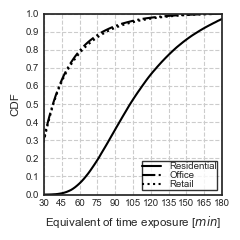

In [6]:
# Inspect simulation results
mcs_out_1 = mcs_1.mcs_out
dict_teq_1 = {case: mcs_out_1.loc[mcs_out_1['case_name'] == case]["solver_time_equivalence_solved"] / 60.0 for case in cases_to_run}
dict_teq_1 = {k: v[~np.isnan(v)] for k, v in dict_teq_1.items()}  # remove np.nan values, non convergency iterations

dict_func_teq2cdf = {k: make_func_teq2cdf(teq=v) for k, v in dict_teq_1.items()}
dict_func_cdf2teq = {k: make_func_cdf2teq(teq=v) for k, v in dict_teq_1.items()}

fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=100)
lss=['-', '-.', 'dotted']
FRs = np.linspace(0, 180, 100)
for i, case in enumerate(cases_to_run):
    ax.plot(FRs, dict_func_teq2cdf[case](FRs), label=case, ls=lss[i], c='k')
format_ax(ax=ax, xlabel='Equivalent of time exposure [$min$]', ylabel='CDF', xlim=(30, 180), ylim=(0, 1), xticks=np.arange(30, 181, 15,), yticks=np.arange(0, 1.1, 0.1))

savefig(fig, 'teq_1.png')

It is obvious Residential produced much worse time equivalence results comparing to the other two, primarily due to higher fuel load density.

### Comparing agsint Kirby et al

| FR  | Office | Retail  | Residential |
|-----|--------|---------|-------------|
| 30  | 0.464  | 0.40416 | 0.16901     |
| 45  | 0.6474 | -       | 0.19285     |
| 60  | 0.8    | 0.73384 | 0.36078     |
| 75  | 0.8963 | -       | 0.62947     |
| 90  | 0.928  | 0.91238 | 0.84399     |
| 105 | 0.9727 | -       | 0.95341     |
| 120 | 0.982  | 0.96824 | 0.99133     |

In [7]:
teq_cdf_kirby = [  # order matters!
    [[60, 75, 90, 105, 120], [0.361, 0.629, 0.844, 0.953, 0.991]],  # Residential
    [[30, 60, 90, 120], [0.464, 0.800, 0.928, 0.982]],  # Office
    [[30, 60, 90, 120], [0.404, 0.734, 0.912, 0.968]],  # Retail
]

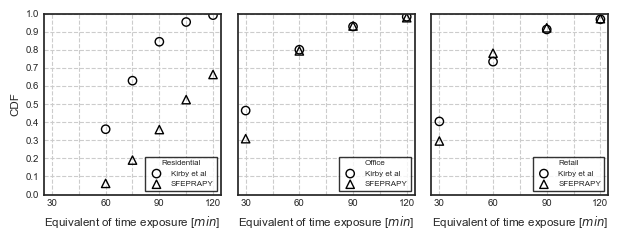

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(2.1*3, 2.5), sharex=True, sharey=True, dpi=100)

for i, case in enumerate(cases_to_run):
    ax = axes[i]
    ax.scatter(teq_cdf_kirby[i][0], teq_cdf_kirby[i][1], label='Kirby et al', marker='o', facecolors='none', edgecolors='k')
    ax.scatter(teq_cdf_kirby[i][0], dict_func_teq2cdf[case](teq_cdf_kirby[i][0]), label='SFEPRAPY', marker='^', facecolors='none', edgecolors='k')
    format_ax(ax=ax, xlabel='Equivalent of time exposure [$min$]', xticks=np.arange(30, 121, 30), xticks_minor=np.arange(30, 121, 15), ylim=(0, 1), yticks=np.arange(0, 1.1, 0.1), legend_title=case, legend_loc=4, legend_fontsize='xx-small', legend_title_fontsize='xx-small')
axes[0].set_ylabel('CDF', fontsize='small')

savefig(fig, 'benchmark_1.png')